# **Ayudantía 7 - Newton $\mathbb{R}^n$**
## Etienne Rojas

Ante cualquier duda o posible corrección, por favor mandar un correo a `etienne.rojas@sansano.usm.cl` 

---

# **Contexto**
Los ayudantes de laboratorio sostenian un caluroso debate sobre cuánto tiempo se debe revolver el café, porque si ya esta totalmente disuelto, seguir revolviendo es una perdida de tiempo. 

Nuestro objetivo es modelar como se disuelve una distribución inicial uniforme de café soluble en una taza cuadrada. Al revolver el café utilizando un mini batidor, se generan corrientes internas modeladas por un campo de velocidad con la forma de un remolino.

La concentración de café en la taza sigue la ecuación de **advección-difusión bidimensional**:


$$
\frac{\partial c}{\partial t} = D \Delta c - u(x,y) \frac{\partial c}{\partial x} - v(x,y) \frac{\partial c}{\partial y}
$$


- $c(x,y,t)$ es la **concentración del café**, es decir, la cantidad de café en un punto $(x,y)$ en el instante $t$.
- $u(x,y)$ y $v(x,y)$ son los **campos de velocidades**, describiendo cómo se mueve el fluido en cada punto: $u$ en la dirección $x$, $v$ en la dirección $y$.
- $D$ es el **coeficiente de difusión**, que mide la tendencia natural del café a extenderse espontáneamente y suavizarse.
- $\Delta c$ es el **Laplaciano de $c$**, que mide la curvatura de $c$ y controla el efecto de la difusión espacial.

Para responder la pregunta ¿cuánto tiempo es necesario revolver el café? debemos encontrar el estado estacionario del sistema, es decir, cuando la variación de la concentración es nula.

---

# **Consideraciones**


Además considere que usted conoce los siguientes elementos:

1. Los **campos de velocidades** estan dados por:
$$
\begin{aligned}
u(x,y) &= sin(\pi x) cos(\pi y)\\
v(x,y) &=-cos(\pi x) sin(\pi y)
\end{aligned}
$$

2. El **coeficiente de difusión** $D$ es un valor conocido:
$$
D = 0.0005
$$

3. Las condiciones de borde son periódicas.

4. El dominio es cuadrado
$$
(x,y) = \in [0,1] \times [0,1]
$$

5. La condición inical $c(x,y,0)$ consiste en una distribución uniforme de café, lo cual se modela así:
$$
c(x,y,0) = C_0
$$

---

# **Discretización**

## **Discretización del Dominio**
El dominio $[0,1] \times [0,1]$ se divide en una mmala de puntos. Podemos definir el tamaño de paso en cada dirección como $h_x$ y $h_y$. Para un cuadrado podemos usar $h = h_x = h_y$. Los puntos de la malla se pueden indexar como $(x,y)$. Además necesitamos definir el avance del tiempo con un $h_t$
$$
\begin{align*}
x_i = i \cdot h \\
y_i = i \cdot h \\
t_i = i \cdot h_t
\end{align*}
$$

Dado que buscamos el estado estacionario, la derivada temporal es nula, por lo que la EDP se reduce a una ecuación de estado estacionario:
$$
D \Delta c - u(x,y) \frac{\partial c}{\partial x} - v(x,y) \frac{\partial c}{\partial y} = 0
$$
Para resolverla, aproximaremos las derivadas espaciales utilizando el método de **diferencias finitas**.

#### Término de Difusión (Laplaciano)
El término de difusión $\Delta c = \frac{\partial^2 c}{\partial x^2} + \frac{\partial^2 c}{\partial y^2}$ se aproxima utilizando la **diferencia central finita de segundo orden** para cada derivada parcial, lo que produce una aproximación de la derivada en el punto $(i,j)$ de la malla:
$$
\Delta c \bigg|_{i,j} \approx \frac{c_{i+1,j}+ c_{i-1,j} + c_{i,j+1} + c_{i,j-1} -4c_{i,j} }{h^2}
$$
Este esquema de diferencias finitas relaciona la concentración en un punto central con sus cuatro vecinos directos (arriba, abajo, izquierda y derecha). 

#### Términos de Advección
Los términos de advección también se aproximan usando **diferencias finitas centradas de segundo orden**. Las derivadas parciales en el punto $(i,j)$ se aproximan como:
$$
\begin{align*}
\frac{\partial c}{\partial x} \bigg|_{i,j} &\approx \frac{c_{i+1,j} -c_{i-1,j}}{2h} \\
\frac{\partial c}{\partial y} \bigg|_{i,j} &\approx \frac{c_{i,j+1} -c_{i,j-1}}{2h}
\end{align*}
$$
Las velocidades $u$ y $v$ se evalúan en cada punto de la malla, $u_{i,j} = u(x_i, y_j)$ y $v_{i,j} = v(x_i, y_j)$.

#### Ecuación Discreta y Sistema de Ecuaciones
Al sustituir las aproximaciones de diferencias finitas en la EDP de estado estacionario, obtenemos un sistema de ecuaciones para cada punto de la malla $(i,j)$:
$$
D \left( \frac{c_{i+1,j}+ c_{i-1,j} + c_{i,j+1} + c_{i,j-1} -4c_{i,j} }{h^2} \right) - u_{i,j} \left( \frac{c_{i+1,j} -c_{i-1,j}}{2h} \right) - v_{i,j} \left( \frac{c_{i,j+1} -c_{i,j-1}}{2h} \right) = 0
$$
Este conjunto de ecuaciones representa el **residuo** del sistema. Cuando estas ecuaciones se satisfacen para todos los puntos de la malla, la solución está en equilibrio. Si se organiza la concentración $c_{i,j}$ en un vector aplanado $\mathbf{c}$, el problema se convierte en encontrar la raíz del sistema de ecuaciones no lineales $F(\mathbf{c}) = 0$.

# **PROGRAMACIÓN**

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.ndimage import map_coordinates


### **FUNCIONES AUXILIARES**

In [13]:

def velocity_field(X, Y):
    """Define el campo de velocidad."""
    u = np.sin(np.pi * X) * np.cos(np.pi * Y)
    v = -np.cos(np.pi * X) * np.sin(np.pi * Y)
    return u, v

def initial_concentration(X, Y):
    """Crea 5 concentraciones formando un pentágono de concentración inicial."""
    c0 = np.zeros_like(X)
    center_x, center_y = 0.5, 0.5
    radius = 0.45
    angles = np.linspace(0, 2*np.pi, 6)[:-1]  

    for angle in angles:
        px = center_x + radius * np.cos(angle)
        py = center_y + radius * np.sin(angle)
        c0 += np.exp(-100 * ((X - px)**2 + (Y - py)**2))
    return c0

# def initial_concentration(X, Y, C0=1.0):
#     """Crea una concentración inicial uniforme."""
#     return np.full_like(X, C0)

def plot_concentration(c, title='Estado Estacionario'):
    """Grafica la concentración."""
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(
        c, extent=(0,1,0,1), origin='lower', cmap='plasma',
        vmin=0, vmax=1
    )
    plt.axis('off')
    cbar = plt.colorbar(im, ax=ax, label='Concentración')
    cbar.set_ticks(np.linspace(0, 1, 6))
    plt.title(title)
    plt.show()

### **FUNCIONES A COMPLETAR**

In [14]:
def compute_residual(c_flat, D, u, v, h):
    """
    Calcula el residuo F(c) para la ecuación de estado estacionario.
    
    Parámetros:
    - c_flat: ndarray, concentración actual aplanada.
    - D: coeficiente de difusión.
    - u, v: campos de velocidad en la malla.
    - h: tamaño del paso espacial.

    Retorna:
    - F_flat: ndarray, vector de residuo aplanado.
    """
    n = int(np.sqrt(c_flat.size))
    c = c_flat.reshape((n, n))
    
    # Término de difusión
    diffusion = D * (
        np.roll(c, 1, axis=0) + np.roll(c, -1, axis=0) +
        np.roll(c, 1, axis=1) + np.roll(c, -1, axis=1) - 4 * c
    ) / h**2
    
    # Término de advección
    advection = u * (np.roll(c, -1, axis=1) - np.roll(c, 1, axis=1)) / (2 * h) + \
                v * (np.roll(c, -1, axis=0) - np.roll(c, 1, axis=0)) / (2 * h)
    
    # El residuo F(c) = Difusión - Advección
    F = diffusion - advection
    
    return F.flatten()

def approximate_jacobian(F, c, D, u, v, h, epsilon=1e-6):
    """
    Aproxima la matriz Jacobiana J_F de la función F en el punto c.
    """
    n2 = c.size
    J = np.zeros((n2, n2))
    
    F0 = F(c, D, u, v, h)
    
    for i in range(n2):
        c_perturbed = c.copy()
        c_perturbed[i] += epsilon
        F_perturbed = F(c_perturbed, D, u, v, h)
        J[:, i] = (F_perturbed - F0) / epsilon
    
    return J

def newton_solver(F, c0_flat, D, u, v, h, tol=1e-6, max_iter=20):
    """
    Resuelve F(c) = 0 para encontrar el estado estacionario.
    """
    c = c0_flat.copy()
    for iteration in range(max_iter):
        F_c = F(c, D, u, v, h)
        norm_F = np.linalg.norm(F_c)
        print(f"Iteración {iteration}: ||F(c)|| = {norm_F:.2e}")
        
        if norm_F < tol:
            print("Convergencia alcanzada.")
            break
            
        J = approximate_jacobian(F, c, D, u, v, h)
        
        try:
            delta_c = np.linalg.solve(J, -F_c)
            c += delta_c
        except np.linalg.LinAlgError:
            print("Error: La matriz Jacobiana es singular. Abortando.")
            break
    else:
        print("El método de Newton no convergió después del número máximo de iteraciones.")
    
    return c

### **GRAFICAR RESULTADOS**

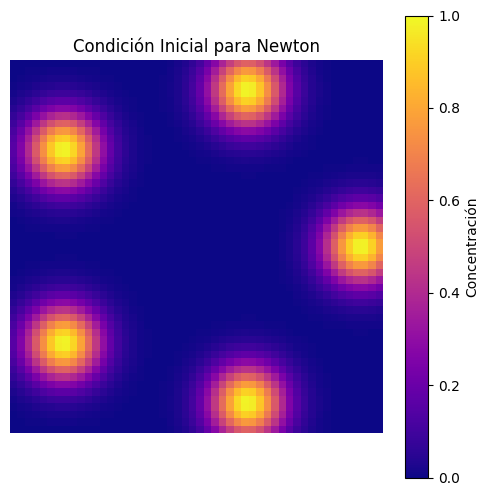

Iniciando el solver de Newton para el estado estacionario...
Iteración 0: ||F(c)|| = 1.09e+02
Iteración 1: ||F(c)|| = 3.34e-08
Convergencia alcanzada.


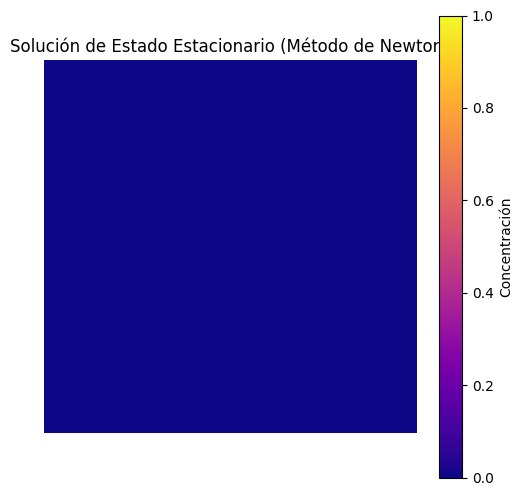

In [16]:
N = 50       # Número de puntos en cada dimensión
h = 1.0 / (N - 1)
D = 0.0005
C0_initial = 1.0 # Concentración inicial para la adivinanza

# Malla y campos
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)
u, v = velocity_field(X, Y)

# Condición inicial (adivinanza inicial para Newton)
c0 = initial_concentration(X, Y)
c0_flat = c0.flatten()
    
plot_concentration(c0, title='Condición Inicial para Newton')
    
# Resolviendo el problema de estado estacionario con el Método de Newton
print("Iniciando el solver de Newton para el estado estacionario...")
c_steady_flat = newton_solver(compute_residual, c0_flat, D, u, v, h)
    
# Graficar la solución final
c_steady = c_steady_flat.reshape(N, N)
plot_concentration(c_steady, title='Solución de Estado Estacionario (Método de Newton)')

# CODIGO OPCION 2